## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls -la /content/drive/MyDrive/CreditCard_Fraud_Detection/creditcard.csv

-rw------- 1 root root 150828752 Oct 30 10:17 /content/drive/MyDrive/CreditCard_Fraud_Detection/creditcard.csv


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing

# Helper Functions

In [4]:
# plot the histogram of a variable from the dataset to see the skewnes
def plot_skewness_histogram(df):
    k = 0
    plt.figure(figsize=(12, 20))
    for col in df.columns:
      k=k+1
      plt.subplot(6, 5, k)
      sns.histplot(df[col])
      plt.tight_layout()
      plt.title(col + ' (Skewness =' + str(round(df[col].skew(), 3)) +')')

In [5]:
# Helper Function to test the classification model

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
import json


def test_classification_model(model, X, y, test_size=0.2, random_state=42, hyperparameters=None):
    """
    Test a classification model and return evaluation metrics.

    Parameters:
    - model: The classification model to test (e.g., RandomForestClassifier, LogisticRegression, etc.).
    - X: The feature matrix.
    - y: The target vector.
    - test_size: The proportion of the dataset to include in the test split (default is 0.2).
    - random_state: Seed for random number generator for reproducibility (default is 42).
    - hyperparameters: Dictionary of hyperparameters for model tuning (default is None).

    Returns:
    - Dictionary containing the evaluation metrics: accuracy, precision, recall, F1 score, and confusion matrix.
    """
    print("Processing for the Model : {} ".format(model))
    # Split the dataset into training and testing sets
    print("Splitting train and test for the Model : {} ".format(model))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Creating KFold object with 5 splits
    print("Creating KFold object with 5 splits")
    folds = KFold(n_splits=5, random_state=4, shuffle=True)
    print("Configuring hyper parameter  for the Model : {}  with hyperparamer {}".format(model,hyperparameters))
    if hyperparameters is not None:
        # Perform hyperparameter tuning using GridSearchCV
        grid_search = GridSearchCV(model, param_grid = hyperparameters, cv=folds,verbose=2, scoring ='roc_auc',return_train_score=True)
        grid_search.fit(X_train, y_train)
        model_cv = grid_search.best_estimator_
    print("Fitting the Model : {} ".format(model))
    # Fit the model to the training data
    model_cv.fit(X_train, y_train)

    print("Predicting  the Model : {} ".format(model))
    # Make predictions on the test data
    y_pred = model_cv.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    TP = confusion[1,1] # true positive
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    sensitivity = TP / float(TP+FN)
    specificity = TN / float(TN+FP)

    # Calculate ROC curve and ROC AUC score
    y_prob = model_cv.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)





    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Store the metrics in a dictionary
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': confusion,
        'ROC AUC': roc_auc,
        'sensitivity':sensitivity,
        'specificity' : specificity,
        'Best_Model' : model_cv
    }
    # results of GridSearchCV
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print("The CV results for the model {} ".format(model))
    display(cv_results)


    print("The Metrics for the best score {}  and Best Estimator {} ".format(grid_search.best_score_,grid_search.best_estimator_))
    return metrics

In [6]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [7]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

def perform_resampling(X, y, method='random'):
    """
    Resample the imbalanced dataset using RandomOverSampler, SMOTE, or ADASYN.

    Parameters:
        X (array-like): The feature matrix.
        y (array-like): The target vector.
        method (str): The resampling method to use ('random', 'smote', or 'adasyn').

    Returns:
        X_resampled (array-like): The resampled feature matrix.
        y_resampled (array-like): The resampled target vector.
    """
    if method == 'random':
        sampler = RandomOverSampler(random_state=42)
    elif method == 'smote':
        sampler = SMOTE(random_state=42)
    elif method == 'adasyn':
        sampler = ADASYN(random_state=42)
    else:
        raise ValueError("Invalid resampling method. Use 'random', 'smote', or 'adasyn'.")

    X_resampled, y_resampled = sampler.fit_resample(X, y)
    return X_resampled, y_resampled

In [8]:
# Create an empty DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score' , 'Best_Model','Confusion Matrix','ROC AUC', 'Threshold' ,'ROC AUC - Test Data'])

def create_classification_report(models,metrics_df,X_train, y_train):
    # Test each model and store the metrics in the DataFrame
    for model_name, (model, hyperparameters) in models.items():
        metrics_info = test_classification_model(model,X_train, y_train,hyperparameters=hyperparameters)
        metrics_df = metrics_df.append({'Model': model_name, **metrics_info}, ignore_index=True)
        #display(metrics_df)
    # Display the metrics DataFrame
    print("Final Metrics and the Model information")
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX\n\n")
    display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))
    return metrics_df

In [9]:
def create_model_threshold(models,metrics_df):
    import warnings

    # Disable the warning
    warnings.filterwarnings('ignore', message="X does not have valid feature names")
    # Predictions on the test set using Logistic regression  and XgBost
    from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report,roc_curve
    #metrics_df['Threshold'] = "NA"
    #metrics_df['ROC AUC - Test Data'] = "NA"
    from sklearn import metrics
    for key in models.keys():
        #print(key)
        best_model = metrics_df[metrics_df['Model'] == key]['Best_Model'].values[0]
        #print(best_model)
        pred_proba = best_model.predict_proba(X_test)[:,1]
        auc = metrics.roc_auc_score(y_test, pred_proba)
        print("AUC score for the Model {} : {}".format(key,auc))
        #print('Train auc  =', metrics.roc_auc_score(y_test,pred_proba))
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba)

        threshold = thresholds[np.argmax(tpr-fpr)]
        print("Threshold for the model {}  = {} ".format(key,threshold))
        print("================================ ")
        metrics_df.loc[metrics_df['Model'] == key , 'Threshold'] = threshold
        metrics_df.loc[metrics_df['Model'] == key , 'ROC AUC - Test Data'] = auc
        #display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))
        print("RoC curve for model {} ".format(key))
        print("================================ ")
        draw_roc(y_test, pred_proba)
        #print("Clasification Report for {}".format(key))
        #print("================================ ")
        #print(classification_report(y_test, pred_proba))
    return metrics_df

## Exploratory data analysis

In [10]:
df = pd.read_csv('/content/drive/MyDrive/CreditCard_Fraud_Detection/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
#observe the different feature type present in the data
df.shape

(284807, 31)

In [12]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [13]:
#Check the Means and Standard deviation to undetstand if we need to scale it
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [14]:
# Check for any null Values . NO NULL VALUES !!!!
df.isnull().sum().sum()

0

In [15]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [16]:
# You can see 99% is with Class0 and less than 1% is with class1 . so it is highly imba,lanced
df['Class'].value_counts(normalize = True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

Here we will observe the distribution of our classes

In [17]:
classes=df['Class'].value_counts()

normal_count = classes[0]
fraud_count = classes[1]
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

In [18]:
plot_data = pd.DataFrame({'Count': [normal_count, fraud_count], 'Percentage': [normal_share, fraud_share]}, index=['Non-Fraudulent', 'Fraudulent'])
plot_data


,Count,Percentage
Non-Fraudulent,284315,99.827251
Fraudulent,492,0.172749


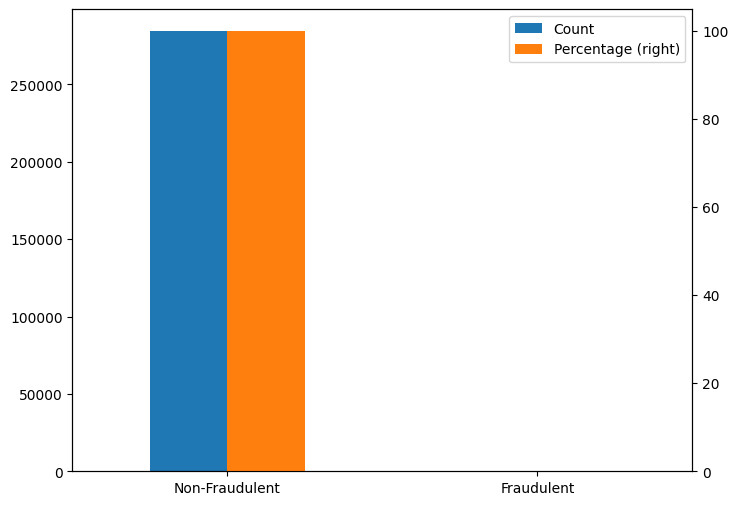

In [19]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
plot_data.plot(kind='bar', secondary_y='Percentage', rot=0, figsize=(8, 6))
plt.show()

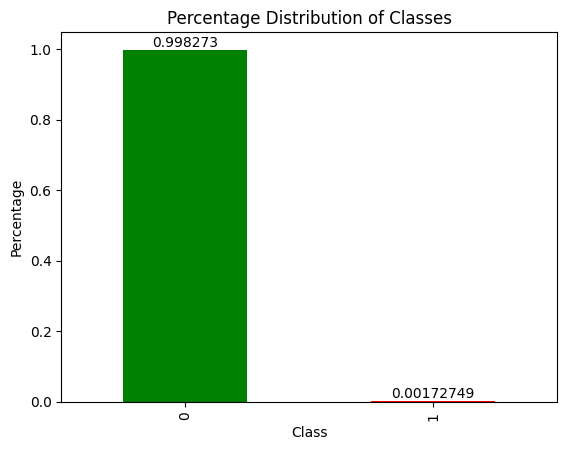

In [20]:
ax = df['Class'].value_counts(normalize = True).plot.bar(color = ['g', 'r'])
ax.bar_label(ax.containers[0], label_type='edge')
plt.title('Percentage Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.show()

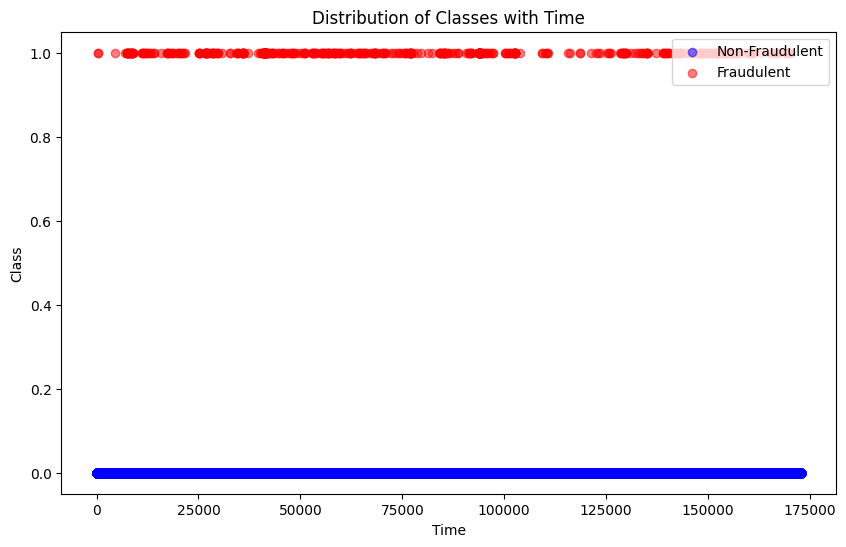

In [21]:
# Create a scatter plot to observe the distribution of classes with time

import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Time'][df['Class'] == 0], df['Class'][df['Class'] == 0], label='Non-Fraudulent', alpha=0.5, c='b')
plt.scatter(df['Time'][df['Class'] == 1], df['Class'][df['Class'] == 1], label='Fraudulent', alpha=0.5, c='r')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Class')
plt.title('Distribution of Classes with Time')
plt.legend(loc='upper right')
plt.show()

# We don;t see any Fradulant with the Time Coloum so probably we can drop this

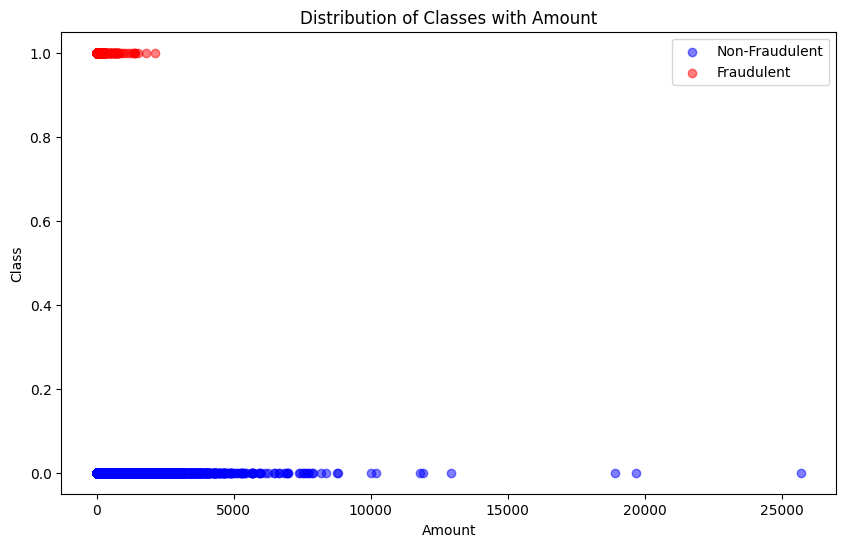

In [22]:
# Create a scatter plot to observe the distribution of classes with Amount
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Amount'][df['Class'] == 0], df['Class'][df['Class'] == 0], label='Non-Fraudulent', alpha=0.5, c='b')
plt.scatter(df['Amount'][df['Class'] == 1], df['Class'][df['Class'] == 1], label='Fraudulent', alpha=0.5, c='r')

# Customize the plot
plt.xlabel('Amount')
plt.ylabel('Class')
plt.title('Distribution of Classes with Amount')
plt.legend(loc='upper right')
plt.show()



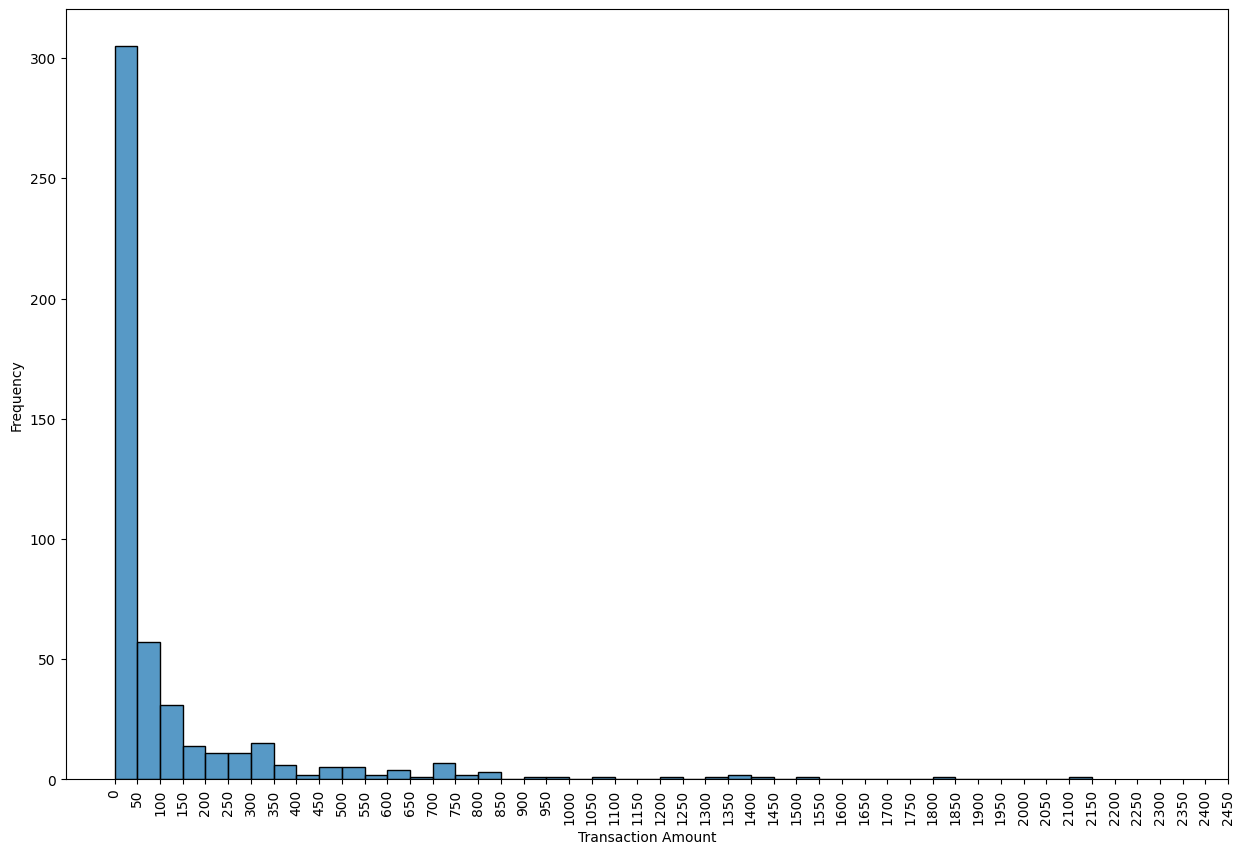

In [23]:
# creating fradulant dataframes
data_fraud = df[df['Class'] == 1]

# Creating non fraudulent dataframe
data_non_fraud = df[df['Class'] == 0]

# distribution of Fradulent data

plt.figure(figsize=(15, 10))
sns.histplot(data_fraud['Amount'], binwidth=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.xticks(range(0, 2500, 50), rotation=90)
plt.show()

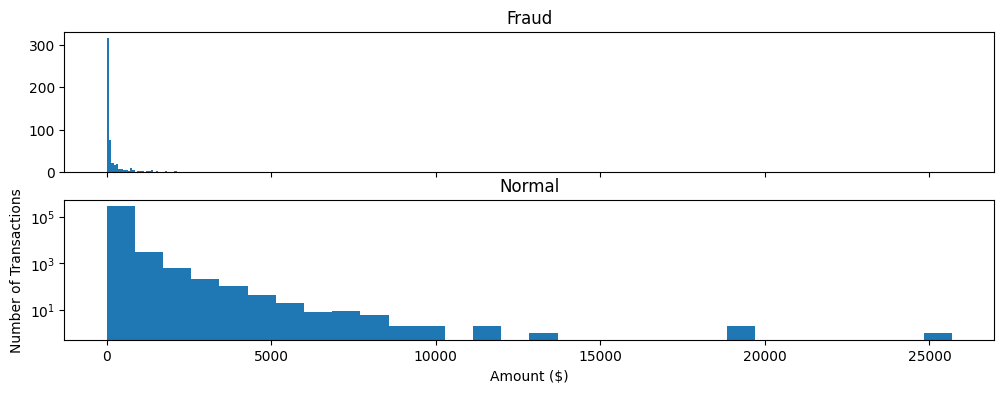

In [24]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

## Correlation

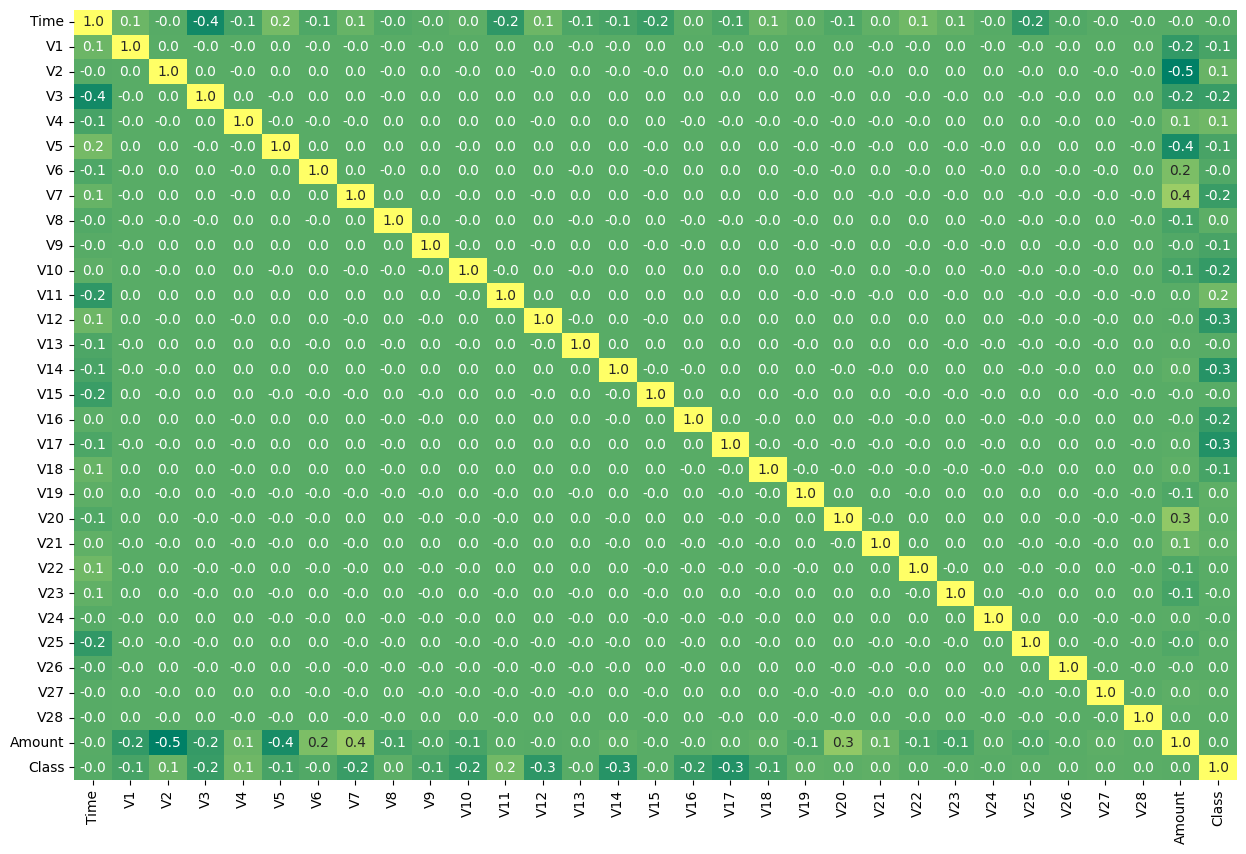

In [25]:

plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cbar=False, fmt='.1f', cmap='summer')
plt.show()

## Outlier

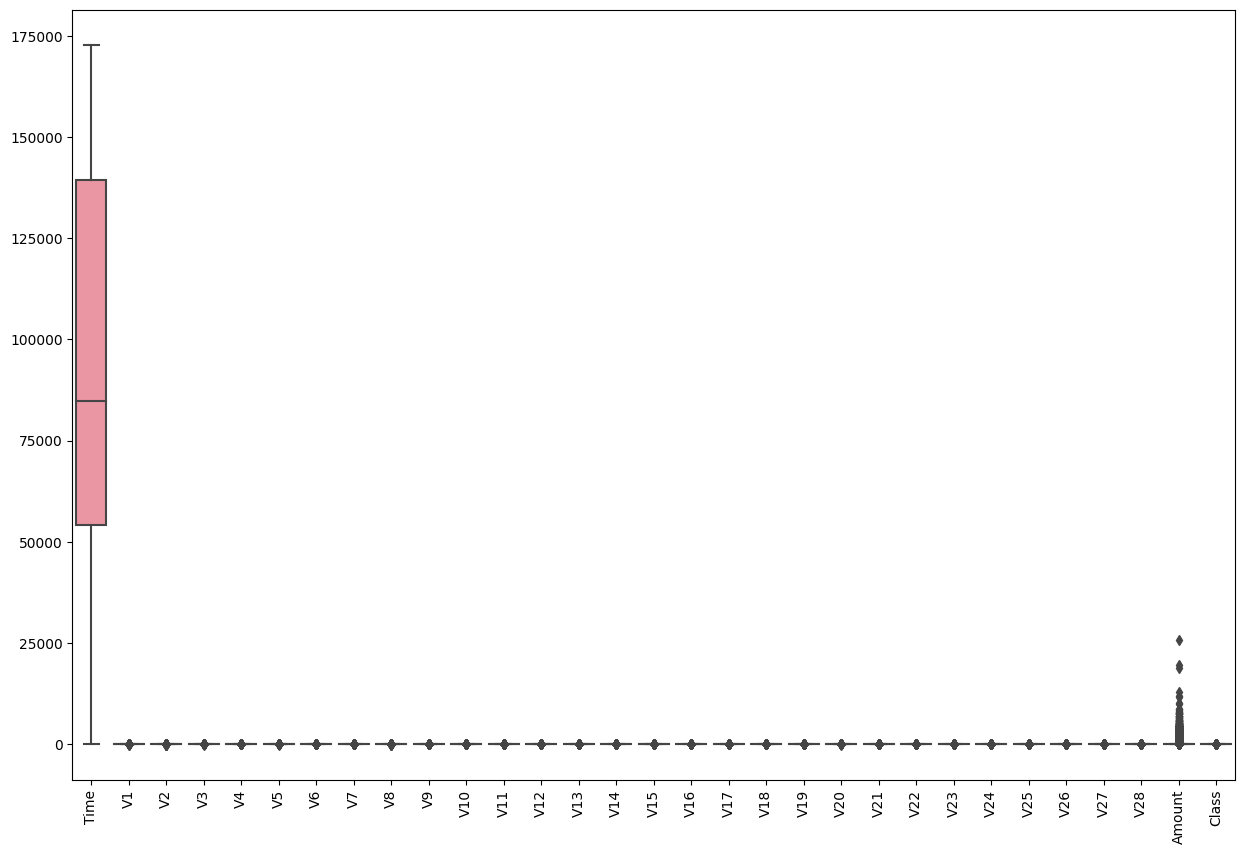

In [26]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

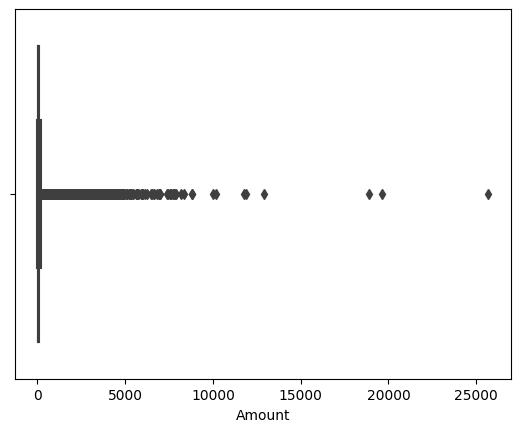

In [27]:
plt.tight_layout()
sns.boxplot(x=df['Amount'], data=df)
plt.show()

#####  Most of the fradulent transactions are in the range of 0-50 dollars

In [28]:
# Drop unnecessary columns. As mentioned above we don;t find much value in "Time" coloumn so dropping it
data = df.drop('Time', axis=1)

In [29]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [30]:
data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [31]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [32]:
display(data.shape)
display(df.shape)

(284807, 30)

(284807, 31)

### Splitting the data into train & test data

In [33]:
from sklearn.model_selection import train_test_split
# Lables on the y
y= data['Class']
#  All features in X
X = data.drop(['Class'], axis=1)

In [34]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, stratify=y, random_state=42)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [35]:
print(" Number of Record  of Total Class : {}".format(y.shape))
print(" Number of Record  of Total Dependent Variable : {}".format(X.shape))
print(" Number of Record  of Total X_train : {}".format(X_train.shape))
print(" Number of Record  of Total y_train : {}".format(y_train.shape))
print(" Number of Record  of Total X_test : {}".format(X_test.shape))
print(" Number of Record  of Total y_test : {}".format(y_test.shape))

 Number of Record  of Total Class : (284807,)
 Number of Record  of Total Dependent Variable : (284807, 29)
 Number of Record  of Total X_train : (199364, 29)
 Number of Record  of Total y_train : (199364,)
 Number of Record  of Total X_test : (85443, 29)
 Number of Record  of Total y_test : (85443,)


In [36]:
X_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,...,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000
mean,-0.001137,-0.002024,-0.001333,0.000313,0.000202,0.000302,-0.000307,-0.001291,0.001995,0.000398,...,-0.001012,0.000459,0.000360,0.000731,-0.000054,-0.000550,0.000072,-0.000405,0.000522,88.384784
std,1.965794,1.658079,1.519820,1.416731,1.387295,1.336558,1.248395,1.198699,1.098649,1.090521,...,0.776632,0.740233,0.726146,0.625116,0.605084,0.521473,0.482197,0.407727,0.329701,253.066081
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,-0.919472,-0.600466,-0.890875,-0.846902,-0.691963,-0.768846,-0.553719,-0.208460,-0.640513,-0.534928,...,-0.211792,-0.228438,-0.542054,-0.162021,-0.354888,-0.317041,-0.326836,-0.070712,-0.052910,5.670000
50%,0.017529,0.064591,0.180371,-0.020802,-0.054897,-0.273921,0.040482,0.022954,-0.050199,-0.093119,...,-0.062695,-0.029121,0.006539,-0.010594,0.041130,0.016344,-0.052065,0.001367,0.011266,22.000000
75%,1.315404,0.804932,1.026038,0.743833,0.611243,0.398847,0.571020,0.326971,0.600147,0.455546,...,0.133000,0.186562,0.528738,0.147946,0.439173,0.350126,0.240930,0.091088,0.078266,77.500000
max,2.451888,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,...,39.420904,27.202839,10.503090,22.083545,4.584549,6.070850,3.517346,31.612198,33.847808,25691.160000


In [37]:
pd.DataFrame(X_test).describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,...,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000
mean,0.002652,0.004723,0.003111,-0.000730,-0.000471,-0.000705,0.000717,0.003012,-0.004654,-0.000929,...,0.002361,-0.001070,-0.000841,-0.001706,0.000125,0.001284,-0.000167,0.000944,-0.001218,88.267570
std,1.942042,1.635401,1.507909,1.413863,1.363668,1.322221,1.210320,1.184152,1.098586,1.084946,...,0.757442,0.721031,0.724668,0.622929,0.606963,0.520825,0.482299,0.393915,0.330973,243.108931
min,-37.558067,-50.383269,-32.454198,-5.600607,-40.427726,-19.996349,-33.239328,-50.688419,-10.842526,-22.187089,...,-28.009635,-22.757540,-8.887017,-32.828995,-2.824849,-8.696627,-1.855355,-9.845808,-8.412267,0.000000
25%,-0.922038,-0.594262,-0.889098,-0.851954,-0.690363,-0.767103,-0.554594,-0.208937,-0.649210,-0.536137,...,-0.211571,-0.228236,-0.542817,-0.161437,-0.353614,-0.317478,-0.327388,-0.071227,-0.053131,5.500000
50%,0.019089,0.068355,0.178479,-0.017874,-0.052915,-0.274978,0.039406,0.020753,-0.053320,-0.092409,...,-0.061898,-0.030267,0.007763,-0.012450,0.040595,0.017118,-0.052227,0.001271,0.011194,21.990000
75%,1.316257,0.800600,1.029617,0.742116,0.614065,0.397743,0.568829,0.328104,0.590206,0.449771,...,0.133089,0.186072,0.528260,0.147063,0.440589,0.352148,0.241009,0.090957,0.078359,76.800000
max,2.454930,17.930550,4.226108,12.132323,28.762671,23.917837,44.054461,18.282168,9.272376,13.811758,...,26.237391,27.202839,8.272233,22.528412,4.022866,7.519589,3.119295,10.507884,22.620072,12910.930000


### Plotting the distribution of a variable

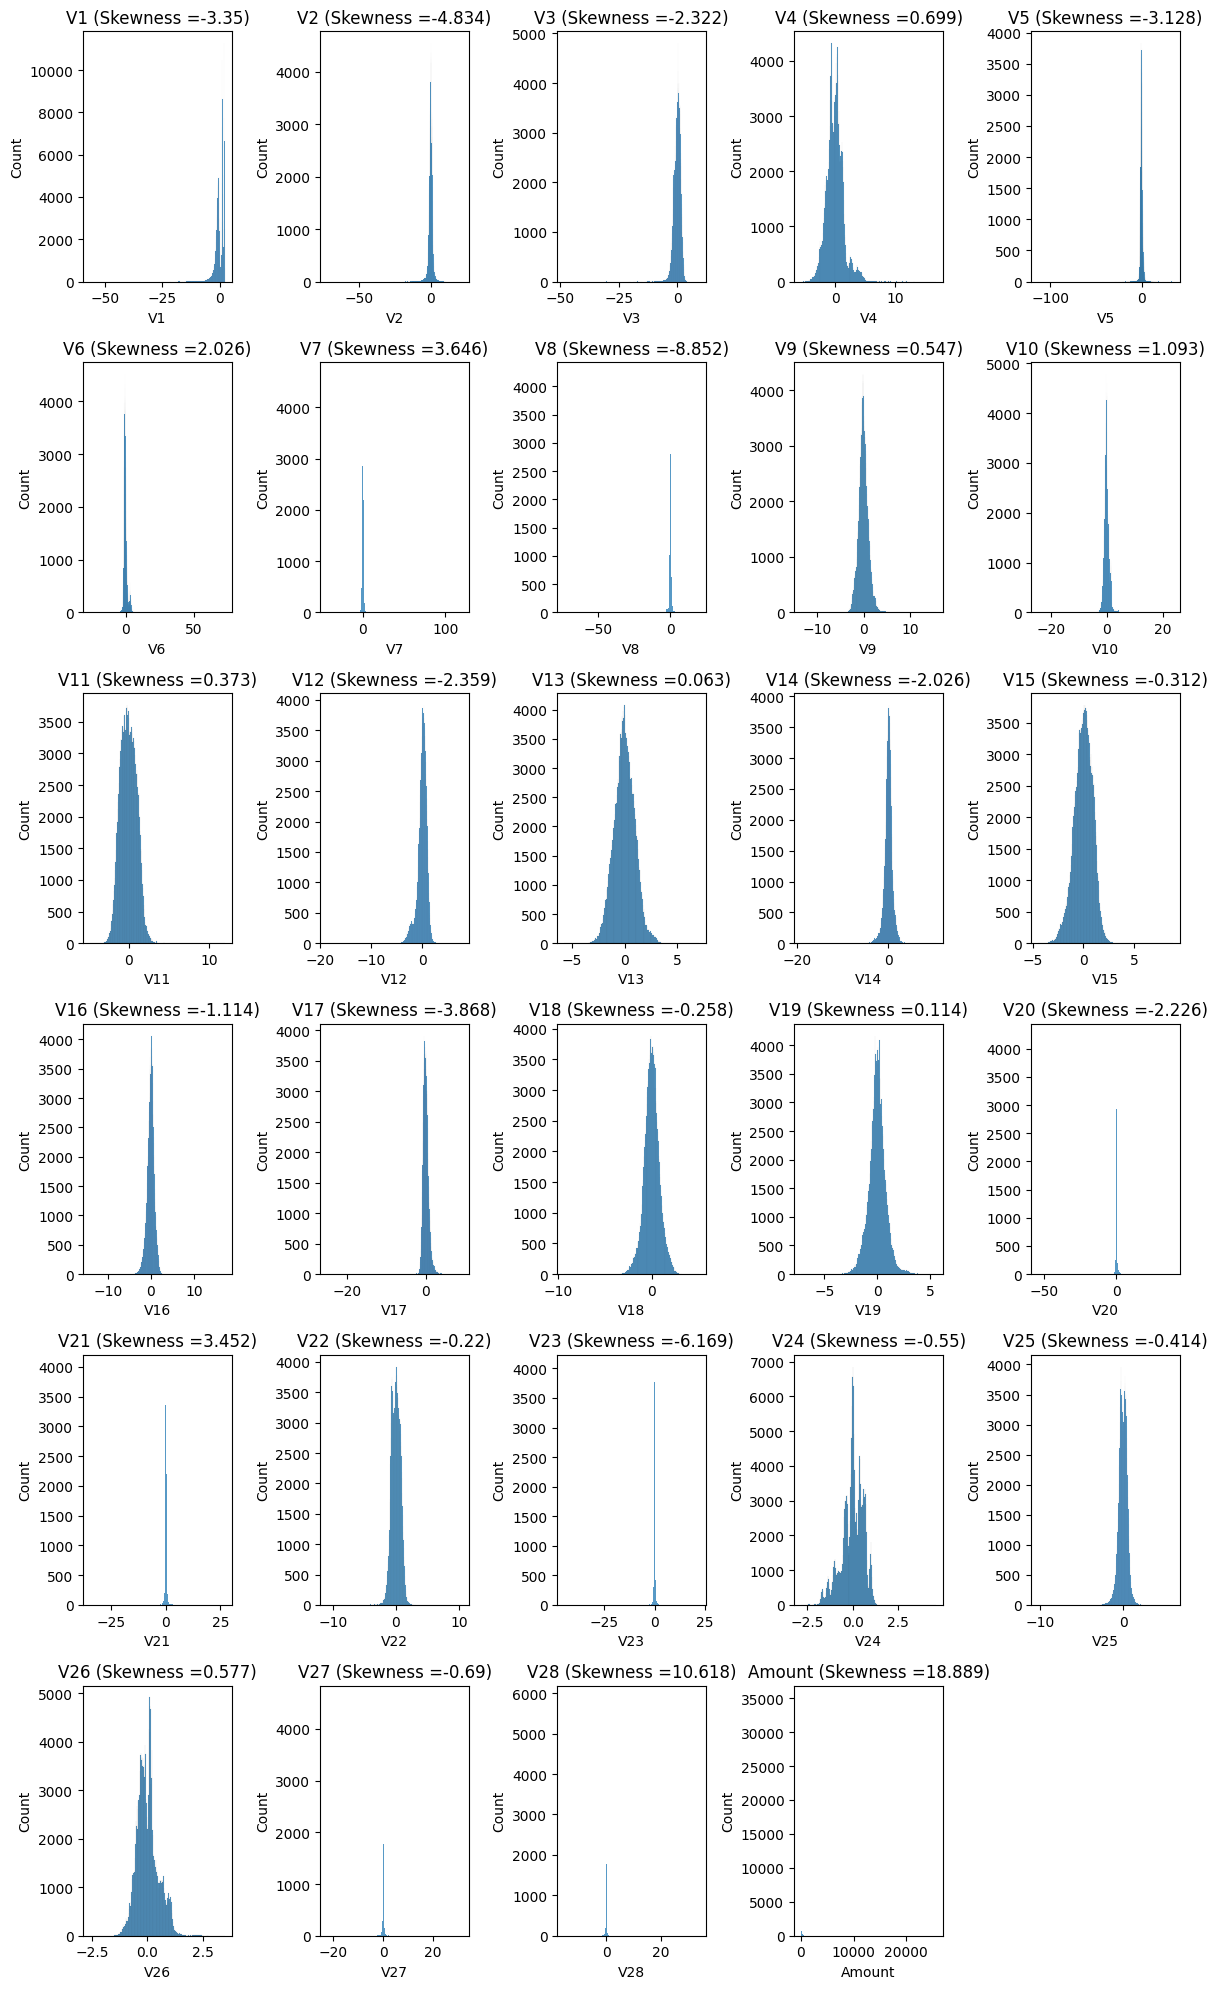

In [38]:
plot_skewness_histogram(X_train)

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [ ]:
# Yes you can see the Skewness in the data .
#- Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
# Based on this https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
#Default is yeo-johnson and the other option is yeo-johnson

#Parameters:
#method{‘yeo-johnson’, ‘box-cox’}, default=’yeo-johnson’
#The power transform method. Available methods are:

#‘yeo-johnson’ [1], works with positive and negative values

#‘box-cox’ [2], only works with strictly positive values

#standardizebool, default=True
#Set to True to apply zero-mean, unit-variance normalization to the transformed output.

#copybool, default=True
#Set to False to perform inplace computation during transformation.

#When you set standardize=True in PowerTransformer, it will first transform your data to have a mean of 0 and a standard deviation of 1, just like what the StandardScaler does. This standardization is applied before the power transformation.

#After standardization, the PowerTransformer performs the power transformation (Box-Cox or Yeo-Johnson) to make the data more Gaussian-like.


In [ ]:
# Capture all Columns
cols = X_train.columns


# Importing PowerTransformer
from sklearn.preprocessing import PowerTransformer

# Instantiate the powertransformer
pt = PowerTransformer(standardize=True, copy=False)

# Fit and transform the PT on training data
X_train[cols] = pt.fit_transform(X_train)

In [ ]:
# Transform the test set as well
X_test = pt.transform(X_test)

In [ ]:
# you can see that the Amount are standardized so no need to standardize again
X_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,...,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05
mean,-4.534304e-17,1.704701e-17,-3.474389e-17,1.456164e-17,1.868403e-17,-1.160613e-17,-3.940556e-17,-7.300907e-18,-1.452071e-17,1.122229e-17,...,3.499184e-17,5.332288e-18,-2.172955e-17,-2.526896e-17,-1.653495e-17,1.281609e-17,-3.758009e-17,-1.185324e-17,-6.026581e-18,-7.314890e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-8.423142e+00,-2.352211e+01,-1.293327e+01,-5.035996e+00,-7.147724e+01,-4.167707e+01,-3.564496e+01,-2.767072e+01,-1.630065e+01,-3.115911e+01,...,-6.559286e+01,-6.222180e+01,-1.327545e+01,-5.840873e+01,-3.539515e+00,-1.465122e+01,-8.026848e+00,-4.568541e+01,-6.006735e+01,-2.014105e+00
25%,-7.225495e-01,-4.534914e-01,-7.121168e-01,-5.677066e-01,-5.087889e-01,-5.565302e-01,-4.418839e-01,-2.757492e-01,-5.605366e-01,-4.737027e-01,...,-2.754652e-01,-3.009014e-01,-7.556592e-01,-2.735518e-01,-6.601130e-01,-6.327912e-01,-6.496852e-01,-1.844458e-01,-1.545649e-01,-7.457231e-01
50%,-2.500047e-01,-4.192011e-02,-2.492247e-02,6.338946e-02,-5.346213e-02,-1.158032e-01,3.494816e-02,-5.506119e-02,5.449009e-03,-4.744744e-02,...,-8.377897e-02,-2.352486e-02,-1.228170e-02,-2.987297e-02,-2.908084e-02,-6.087259e-03,-1.754824e-02,-6.842957e-03,4.421625e-02,2.568798e-02
75%,7.350218e-01,4.762444e-01,6.730424e-01,5.836669e-01,4.323553e-01,4.099482e-01,4.591928e-01,2.565753e-01,5.827192e-01,4.538194e-01,...,1.687240e-01,2.710607e-01,7.205103e-01,2.280991e-01,7.060150e-01,6.581175e-01,5.777305e-01,2.157626e-01,2.502191e-01,7.497848e-01
max,1.865925e+00,2.350533e+01,1.147201e+01,8.501222e+00,2.779986e+01,2.346877e+01,9.392283e+01,3.804417e+01,1.077233e+01,1.651112e+01,...,5.410452e+01,2.960456e+01,1.644871e+01,4.250414e+01,1.238716e+01,1.493682e+01,4.936779e+00,9.830702e+01,7.736510e+01,3.678522e+00


In [ ]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
249927,-0.267697,0.404782,-0.037582,-0.495586,0.417461,-0.450219,0.677525,-0.079224,-0.119844,-0.170534,...,-0.052398,-0.305036,-0.796136,0.056456,-0.669016,-0.954144,0.386449,0.578464,0.267038,-0.619494
214082,1.167168,-0.201782,-1.385696,0.868101,0.434724,-0.791180,0.737052,-0.437967,-0.246955,0.508288,...,-0.042231,0.398622,0.722406,-0.385755,-0.641055,0.951240,-0.898773,-0.195537,-0.166521,1.119765
106005,-0.792373,-2.385479,-0.987745,0.403150,-1.478402,-0.554012,1.280349,-0.714879,-1.218243,0.119978,...,2.863557,0.486079,-1.922162,-1.734577,0.838645,-0.304635,1.660302,-0.783775,0.704921,2.265229
58619,-0.538573,0.640442,-0.551757,-0.515036,1.826026,2.172282,0.039457,0.777160,-0.250948,0.158587,...,0.289018,-0.251382,-0.976642,0.224379,1.768707,-1.469473,0.177960,0.016490,0.784726,-0.870972
191638,-0.596658,0.056559,0.052907,-1.351635,1.933233,2.527105,-0.156943,0.944995,0.474378,-0.229042,...,0.196280,0.245843,1.050549,-0.527474,1.382820,-0.198843,1.242931,0.173308,-0.093808,-0.870972


In [ ]:
pd.DataFrame(X_test).describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,...,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000
mean,0.000508,0.003626,0.002661,-0.000805,-0.000500,-0.000172,0.000848,0.004654,-0.006078,-0.000960,...,0.004248,-0.001596,-0.001725,-0.003971,0.000760,0.003545,-0.000544,0.003029,-0.005220,-0.003818
std,0.997436,0.995017,0.998794,1.000201,0.985887,0.987052,0.970455,1.012351,0.999551,0.988359,...,0.976567,0.971746,0.998126,0.997871,1.002710,0.998903,1.000351,0.959526,0.993745,1.001301
min,-6.695965,-17.528582,-9.817724,-4.952641,-26.343795,-29.771804,-27.151764,-21.139750,-12.814130,-27.790012,...,-34.169088,-39.191568,-10.923127,-43.705220,-3.528194,-12.672744,-5.239353,-21.138137,-30.985384,-2.014105
25%,-0.723664,-0.449848,-0.711113,-0.571756,-0.507654,-0.554910,-0.442588,-0.276190,-0.569136,-0.474893,...,-0.275182,-0.300618,-0.756677,-0.272617,-0.658218,-0.633591,-0.651024,-0.185711,-0.155251,-0.762270
50%,-0.249066,-0.039443,-0.026332,0.065497,-0.052032,-0.116700,0.034086,-0.057228,0.002561,-0.046779,...,-0.082754,-0.025106,-0.010593,-0.032875,-0.030001,-0.004588,-0.017900,-0.007080,0.043993,0.025424
75%,0.735786,0.473055,0.676253,0.582553,0.434433,0.409152,0.457443,0.257781,0.574200,0.448688,...,0.168839,0.270398,0.719829,0.226654,0.708801,0.662245,0.577883,0.215437,0.250502,0.744644
max,1.869233,18.369143,4.151762,6.425007,22.828204,10.149528,34.553965,33.963705,6.815341,10.183124,...,35.718120,29.604561,12.773167,43.417052,10.476356,19.053707,4.519774,30.113074,53.826811,3.368811


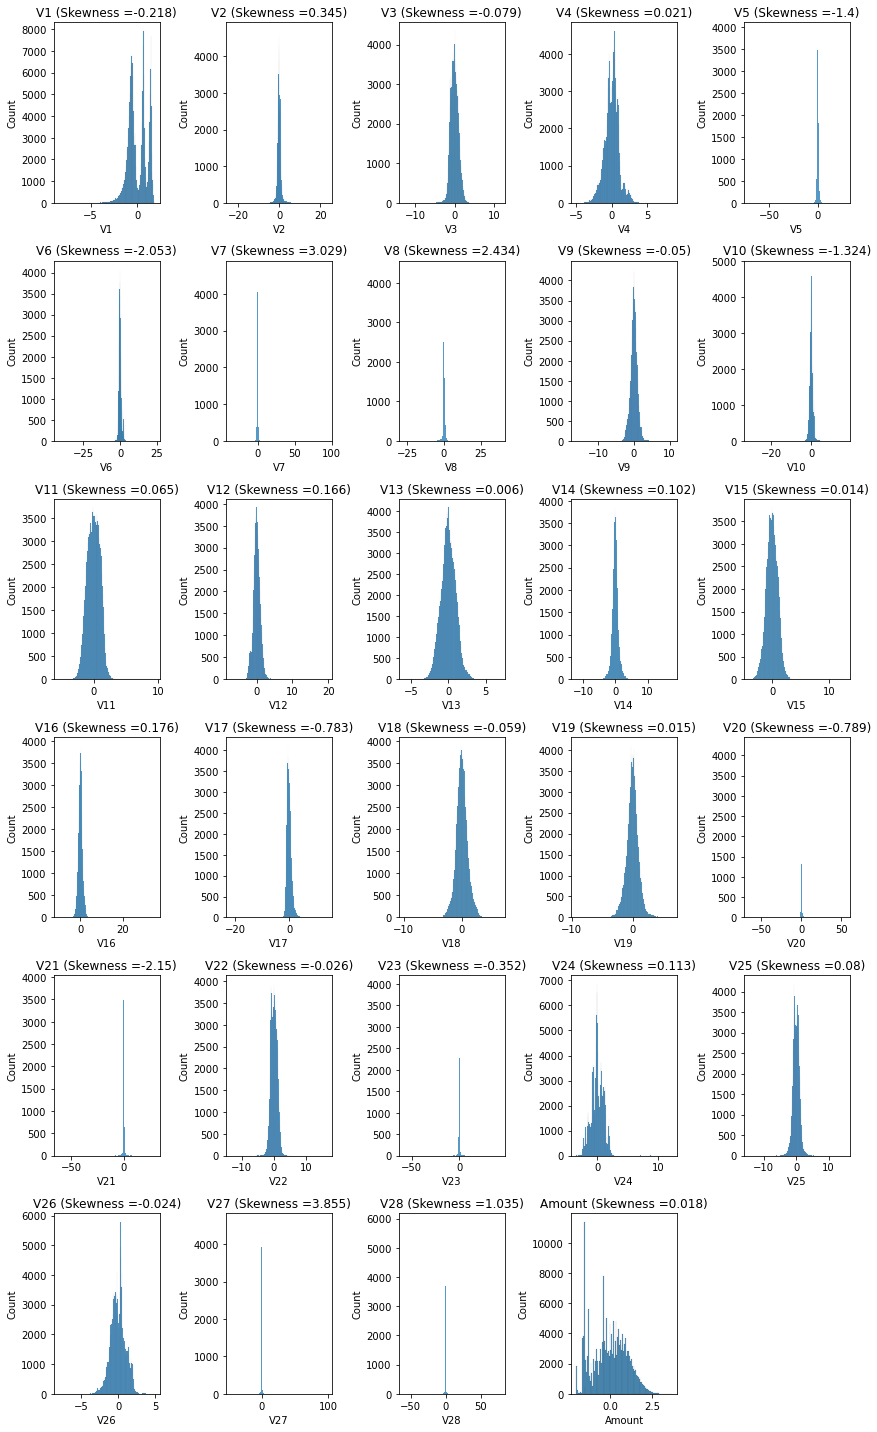

In [ ]:
# plot the histogram of a variable from the dataset again to see the result
plot_skewness_histogram(X_train)

## Model Building
### - Build different models on the imbalanced dataset and see the result

In [ ]:
#!pip install xgboost

# Test each model and store the metrics in the DataFrame
#for model_name, (model, hyperparameters) in models.items():
#    metrics_info = test_classification_model(model,X_train, y_train,hyperparameters=hyperparameters)
#    metrics_df = metrics_df.append({'Model': model_name, **metrics_info}, ignore_index=True)
#    display(metrics_df)
# Display the metrics DataFrame
#print("Final Metrics and the Model information")
#print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX\n\n")
#display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Define the models to test with Hyperparameter
models = {
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [10, 50],
        'max_depth': [ 10,20,30]
    }),
    'Logistic Regression': (LogisticRegression(solver='lbfgs', max_iter=1000), {
        'C': [0.1, 1]
    }),
    'XGBoost' : (XGBClassifier(max_depth=2, n_estimators=200),{
                'learning_rate': [0.2, 0.6],
                'subsample': [0.3, 0.6, 0.9]
    }),
    'DecisionTree' : (DecisionTreeClassifier(),{
                'max_depth': range(5, 15, 5),
                'min_samples_leaf': range(50, 150, 50),
                'min_samples_split': range(50, 150, 50),

    }),
    'KNN' : (KNeighborsClassifier(),{
        'n_neighbors': [3, 5, 7],  # You can adjust the number of neighbors to search
        'weights': ['uniform', 'distance'],
    }),
    'SVM' : (SVC(probability=True),{
        'C': [0.1],  # You can adjust the regularization parameter ijust usedonly one as itis computational intensive
        'kernel': ['linear' ], #rbf is very very comutational intensive so not trying .I just want to show how it will be .In real world you use in GPU with more parameter
    }),
}

In [ ]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data


Processing for the Model : RandomForestClassifier() 
Splitting train and test for the Model : RandomForestClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : RandomForestClassifier()  with hyperparamer {'n_estimators': [10, 50], 'max_depth': [10, 20, 30]}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.1s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.2s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.1s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.2s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.1s
[CV] END ......................max_depth=10, n_estimators=50; total time=  25.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=  25.0s
[CV] END ......................max_depth=10, n_estimators=50; total time= 

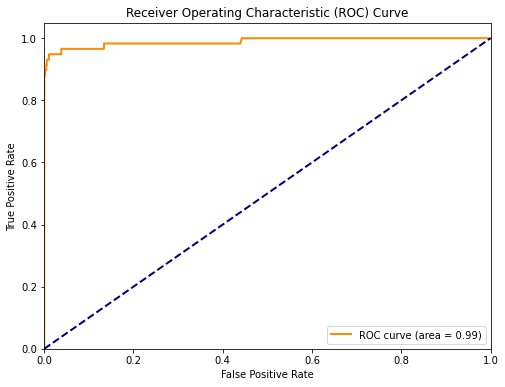

The CV results for the model RandomForestClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.108062,0.058520,0.024879,0.001647,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.953094,0.966509,0.968511,...,0.966656,0.009324,2,0.997015,0.990505,0.986324,0.989831,0.990013,0.990738,3.472350e-03
1,24.927212,0.100142,0.080739,0.001260,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.974083,0.972465,0.967513,...,0.968491,0.012876,1,0.998682,0.997569,0.999432,0.994543,0.998716,0.997788,1.728412e-03
2,6.933710,0.446712,0.027951,0.000758,20,10,"{'max_depth': 20, 'n_estimators': 10}",0.892598,0.924663,0.931606,...,0.926155,0.021518,5,1.000000,0.999999,1.000000,0.999999,0.999999,0.999999,5.009602e-07
3,35.663263,0.869342,0.107366,0.005396,20,50,"{'max_depth': 20, 'n_estimators': 50}",0.924835,0.951801,0.963259,...,0.947080,0.028116,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.791079e-07
4,7.423283,0.255223,0.028074,0.000540,30,10,"{'max_depth': 30, 'n_estimators': 10}",0.893783,0.916273,0.940465,...,0.925724,0.024485,6,0.999998,0.999999,0.999998,0.999999,0.999997,0.999998,6.099612e-07
5,35.823807,1.489466,0.106772,0.006843,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.902544,0.923793,0.965169,...,0.933614,0.023172,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.948077e-09


The Metrics for the best score 0.9684905585356847  and Best Estimator RandomForestClassifier(max_depth=10, n_estimators=50) 
Processing for the Model : LogisticRegression(max_iter=1000) 
Splitting train and test for the Model : LogisticRegression(max_iter=1000) 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : LogisticRegression(max_iter=1000)  with hyperparamer {'C': [0.1, 1]}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..............................................C=0.1; total time=   0.7s
[CV] END ..............................................C=0.1; total time=   0.5s
[CV] END ..............................................C=0.1; total time=   0.6s
[CV] END ..............................................C=0.1; total time=   0.6s
[CV] END ..............................................C=0.1; total time=   0.5s
[CV] END ................................................C=1; total time=   0.8s
[CV] END ................................

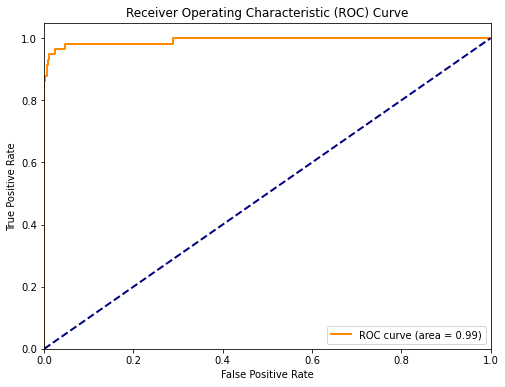

The CV results for the model LogisticRegression(max_iter=1000) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.574767,0.069519,0.010611,0.002216,0.1,{'C': 0.1},0.985767,0.978822,0.972201,0.993589,...,0.981163,0.007671,1,0.985268,0.985256,0.986053,0.983158,0.988635,0.985674,0.001765
1,0.655721,0.084968,0.013460,0.005006,1,{'C': 1},0.983033,0.977001,0.971953,0.994025,...,0.980299,0.007741,2,0.985043,0.984143,0.985419,0.982550,0.988130,0.985057,0.001827


The Metrics for the best score 0.9811629063639288  and Best Estimator LogisticRegression(C=0.1, max_iter=1000) 
Processing for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Splitting train and test for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
    

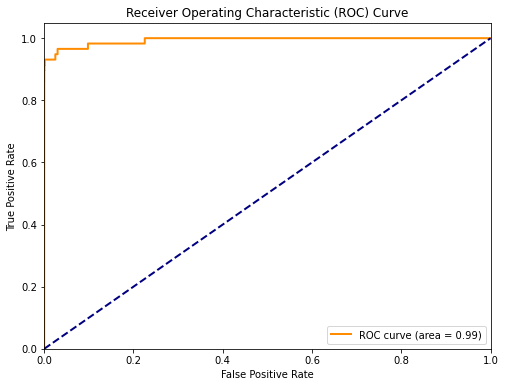

The CV results for the model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.362418,0.078229,0.033288,0.008743,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.962190,0.974564,0.978849,...,0.977082,0.010484,3,0.999894,0.999907,0.999827,0.999474,0.999617,0.999744,0.000170
1,1.437291,0.156572,0.028389,0.005398,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.974586,0.967476,0.978109,...,0.976202,0.011126,4,0.999991,0.999984,0.999919,0.999937,0.999981,0.999963,0.000029
2,1.295549,0.209626,0.025519,0.007522,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.975552,0.975582,0.986912,...,0.980550,0.009061,1,0.999990,0.999965,0.999952,0.999922,0.999984,0.999963,0.000024
3,1.419230,0.128563,0.031245,0.009488,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.944875,0.974370,0.965302,...,0.966210,0.014991,6,0.999998,0.999995,0.999985,0.999986,0.999999,0.999993,0.000006
4,1.319253,0.190366,0.029043,0.009621,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.973699,0.977909,0.967905,...,0.973691,0.013751,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,1.330716,0.114246,0.026339,0.007657,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.967177,0.982916,0.977524,...,0.977265,0.012424,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


The Metrics for the best score 0.9805500090234173  and Best Estimator XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Processing for the Model : DecisionTreeClassifier() 
Splitting train and test for the Model : DecisionTreeClassifier() 
Creating KFold object with 5 splits
Configuring hyper pa

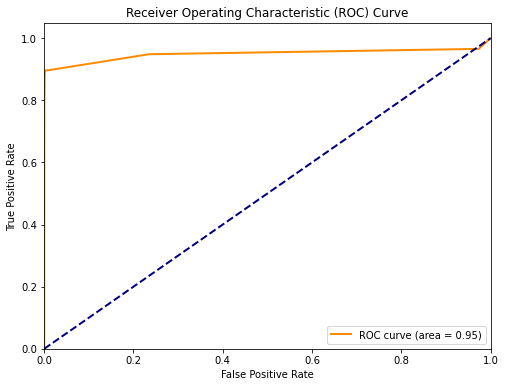

The CV results for the model DecisionTreeClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.126139,0.003378,0.008755,0.000511,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.891121,0.916369,...,0.922582,0.027995,8,0.957599,0.931110,0.958481,0.947409,0.931793,0.945278,0.011944
1,2.133275,0.020318,0.008737,0.000409,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.910319,0.916369,...,0.926424,0.024514,7,0.957599,0.931110,0.958481,0.947409,0.931793,0.945278,0.011944
2,2.137288,0.022935,0.008669,0.000373,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.909744,0.916112,...,0.928965,0.018495,6,0.957217,0.935319,0.961324,0.947203,0.965531,0.953319,0.010861
3,2.129535,0.019568,0.008578,0.000447,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.909744,0.916112,...,0.932343,0.019728,4,0.957217,0.935319,0.961324,0.947203,0.965531,0.953319,0.010861
4,4.188128,0.010923,0.009242,0.000302,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.902782,0.948701,...,0.929978,0.032028,5,0.988157,0.978139,0.985983,0.972753,0.967570,0.978521,0.007770
5,4.181004,0.020933,0.009207,0.000249,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.921714,0.948722,...,0.933764,0.029618,3,0.988162,0.978139,0.985983,0.972753,0.967570,0.978522,0.007771
6,4.178244,0.015014,0.009428,0.000256,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.921426,0.934544,...,0.941116,0.015605,2,0.989937,0.982140,0.989723,0.972257,0.991374,0.985086,0.007181
7,4.165327,0.015524,0.011207,0.003908,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.921737,0.934544,...,0.941181,0.015546,1,0.989937,0.982140,0.989723,0.972257,0.991374,0.985086,0.007181


The Metrics for the best score 0.9411812868844811  and Best Estimator DecisionTreeClassifier(max_depth=10, min_samples_leaf=100,
                       min_samples_split=100) 
Processing for the Model : KNeighborsClassifier() 
Splitting train and test for the Model : KNeighborsClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : KNeighborsClassifier()  with hyperparamer {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=   4.0s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   3.6s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   3.5s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   3.4s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   3.5s
[CV] END ....................n_neighbors=3, weights=dista

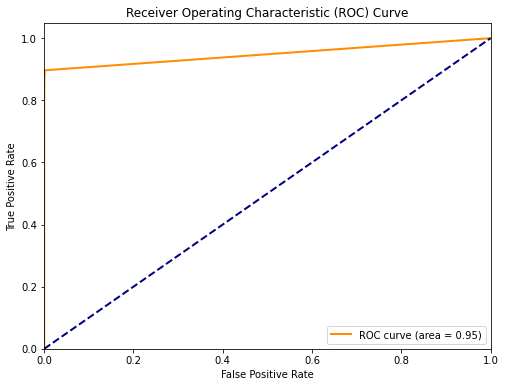

The CV results for the model KNeighborsClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.029962,0.007879,3.579623,0.207117,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.884470,0.899818,0.906687,...,0.908731,0.029191,6,0.999951,0.999948,0.999943,0.999935,0.999951,0.999946,6.251817e-06
1,0.023860,0.000708,3.495573,0.104690,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.884472,0.899825,0.906689,...,0.908737,0.029193,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
2,0.023757,0.000644,3.474248,0.049818,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.884416,0.908129,0.923609,...,0.913756,0.029238,2,0.999910,0.999903,0.999883,0.999876,0.999905,0.999895,1.340101e-05
3,0.023307,0.000571,3.468554,0.099803,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.884429,0.908127,0.923614,...,0.913768,0.029239,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
4,0.030501,0.006191,3.372149,0.019421,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.884364,0.908117,0.923559,...,0.913720,0.029239,4,0.999872,0.999866,0.999841,0.999816,0.999863,0.999852,2.050247e-05
5,0.024191,0.001097,3.436642,0.077698,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.884390,0.908127,0.923572,...,0.913741,0.029241,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.965068e-17


The Metrics for the best score 0.9137677477248495  and Best Estimator KNeighborsClassifier(weights='distance') 
Processing for the Model : SVC(probability=True) 
Splitting train and test for the Model : SVC(probability=True) 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : SVC(probability=True)  with hyperparamer {'C': [0.1], 'kernel': ['linear']}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...............................C=0.1, kernel=linear; total time=  34.4s
[CV] END ...............................C=0.1, kernel=linear; total time=  36.6s
[CV] END ...............................C=0.1, kernel=linear; total time=  37.8s
[CV] END ...............................C=0.1, kernel=linear; total time=  39.8s
[CV] END ...............................C=0.1, kernel=linear; total time=  35.6s
Fitting the Model : SVC(probability=True) 
Predicting  the Model : SVC(probability=True) 


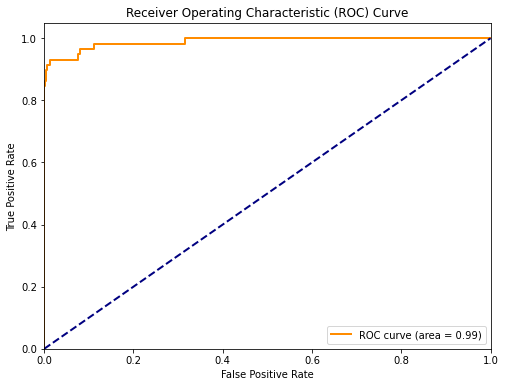

The CV results for the model SVC(probability=True) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,36.635798,1.82869,0.21523,0.013387,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.949837,0.943461,0.966474,...,0.965625,0.017156,1,0.980294,0.97289,0.967719,0.975912,0.979669,0.975297,0.004641


The Metrics for the best score 0.9656249025518747  and Best Estimator SVC(C=0.1, kernel='linear', probability=True) 
Final Metrics and the Model information
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX




,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data,sensitivity,specificity
0,XGBoost,0.999649,0.923077,0.827586,0.872727,"XGBClassifier(base_score=None, booster=None, c...","[[39811, 4], [10, 48]]",0.993420,NaN,NaN,0.827586,0.999900
1,Logistic Regression,0.999273,0.822222,0.637931,0.718447,"LogisticRegression(C=0.1, max_iter=1000)","[[39807, 8], [21, 37]]",0.993083,NaN,NaN,0.637931,0.999799
2,SVM,0.999473,0.836364,0.793103,0.814159,"SVC(C=0.1, kernel='linear', probability=True)","[[39806, 9], [12, 46]]",0.989368,NaN,NaN,0.793103,0.999774
3,Random Forest,0.999624,0.938776,0.793103,0.859813,"(DecisionTreeClassifier(max_depth=10, max_feat...","[[39812, 3], [12, 46]]",0.989016,NaN,NaN,0.793103,0.999925
4,DecisionTree,0.999323,0.762712,0.775862,0.769231,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39801, 14], [13, 45]]",0.949054,NaN,NaN,0.775862,0.999648
5,KNN,0.999599,0.903846,0.810345,0.854545,KNeighborsClassifier(weights='distance'),"[[39810, 5], [11, 47]]",0.948178,NaN,NaN,0.810345,0.999874


In [ ]:
metrics_df = create_classification_report(models,metrics_df,X_train, y_train)

AUC score for the Model Random Forest : 0.9688587541172687
Threshold for the model Random Forest  = 0.0008981066678783913 
RoC curve for model Random Forest 


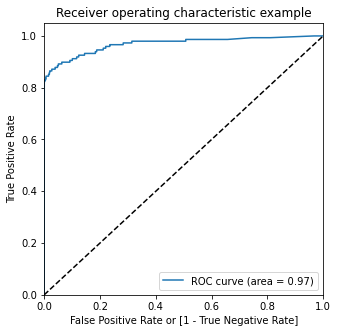

AUC score for the Model Logistic Regression : 0.9673152635606472
Threshold for the model Logistic Regression  = 0.0034452699664573503 
RoC curve for model Logistic Regression 


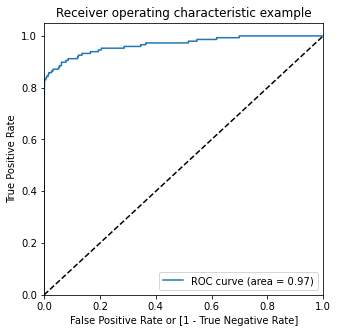

AUC score for the Model XGBoost : 0.9709158041328744
Threshold for the model XGBoost  = 0.0012699400540441275 
RoC curve for model XGBoost 


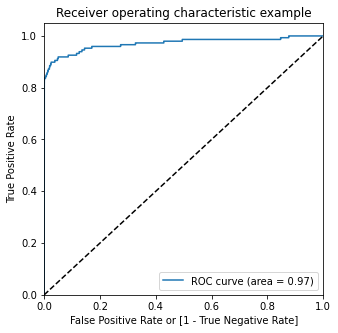

AUC score for the Model DecisionTree : 0.9256744082144164
Threshold for the model DecisionTree  = 0.04 
RoC curve for model DecisionTree 


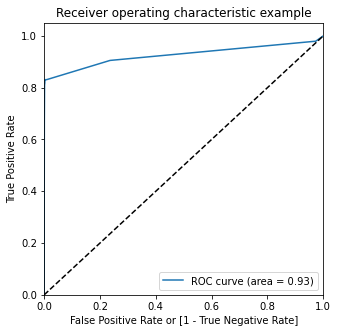

AUC score for the Model KNN : 0.9187726063598037
Threshold for the model KNN  = 0.18331400228363656 
RoC curve for model KNN 


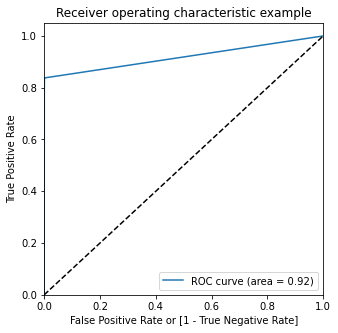

AUC score for the Model SVM : 0.9465086195287261
Threshold for the model SVM  = 0.000996314797100339 
RoC curve for model SVM 


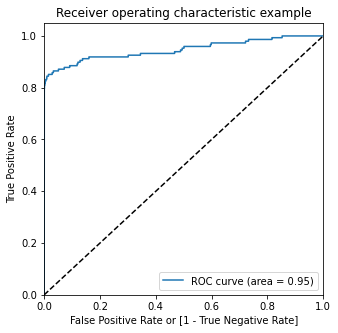

In [ ]:
metrics_df = create_model_threshold(models,metrics_df)

In [ ]:
display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))

,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data,sensitivity,specificity
0,XGBoost,0.999649,0.923077,0.827586,0.872727,"XGBClassifier(base_score=None, booster=None, c...","[[39811, 4], [10, 48]]",0.993420,0.001270,0.970916,0.827586,0.999900
1,Logistic Regression,0.999273,0.822222,0.637931,0.718447,"LogisticRegression(C=0.1, max_iter=1000)","[[39807, 8], [21, 37]]",0.993083,0.003445,0.967315,0.637931,0.999799
2,SVM,0.999473,0.836364,0.793103,0.814159,"SVC(C=0.1, kernel='linear', probability=True)","[[39806, 9], [12, 46]]",0.989368,0.000996,0.946509,0.793103,0.999774
3,Random Forest,0.999624,0.938776,0.793103,0.859813,"(DecisionTreeClassifier(max_depth=10, max_feat...","[[39812, 3], [12, 46]]",0.989016,0.000898,0.968859,0.793103,0.999925
4,DecisionTree,0.999323,0.762712,0.775862,0.769231,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39801, 14], [13, 45]]",0.949054,0.040000,0.925674,0.775862,0.999648
5,KNN,0.999599,0.903846,0.810345,0.854545,KNeighborsClassifier(weights='distance'),"[[39810, 5], [11, 47]]",0.948178,0.183314,0.918773,0.810345,0.999874


We can see that among all the models we tried (Logistic, XGBoost, Decision Tree, and Random Forest), almost all of them have performed well.
More specifically Logistic regression ( roc auc :0.993083) and XGBoost ( roc auc :0.993420 ) performed best in terms of ROC-AUC score.
But if we were to choose one of them , we can go for the best as XGBoost which gives us best ROC score.

NOTE: You should see that best_model is of type RandomForestClassifier, and it should display the parameters of the random forest.

The reason it may show "Decision Tree" in the output is due to the way scikit-learn structures its code. The DecisionTreeClassifier is the base class for individual decision trees used within random forests, and it's possible that the naming convention is inherited from that.

In summary, seeing "Decision Tree" in the output of GridSearchCV when accessing the best_estimator_ attribute is not an issue. It's just a label used by scikit-learn, and the returned model is still a random forest with the best hyperparameters.

### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

Top var = 10
2nd Top var = 14
3rd Top var = 17


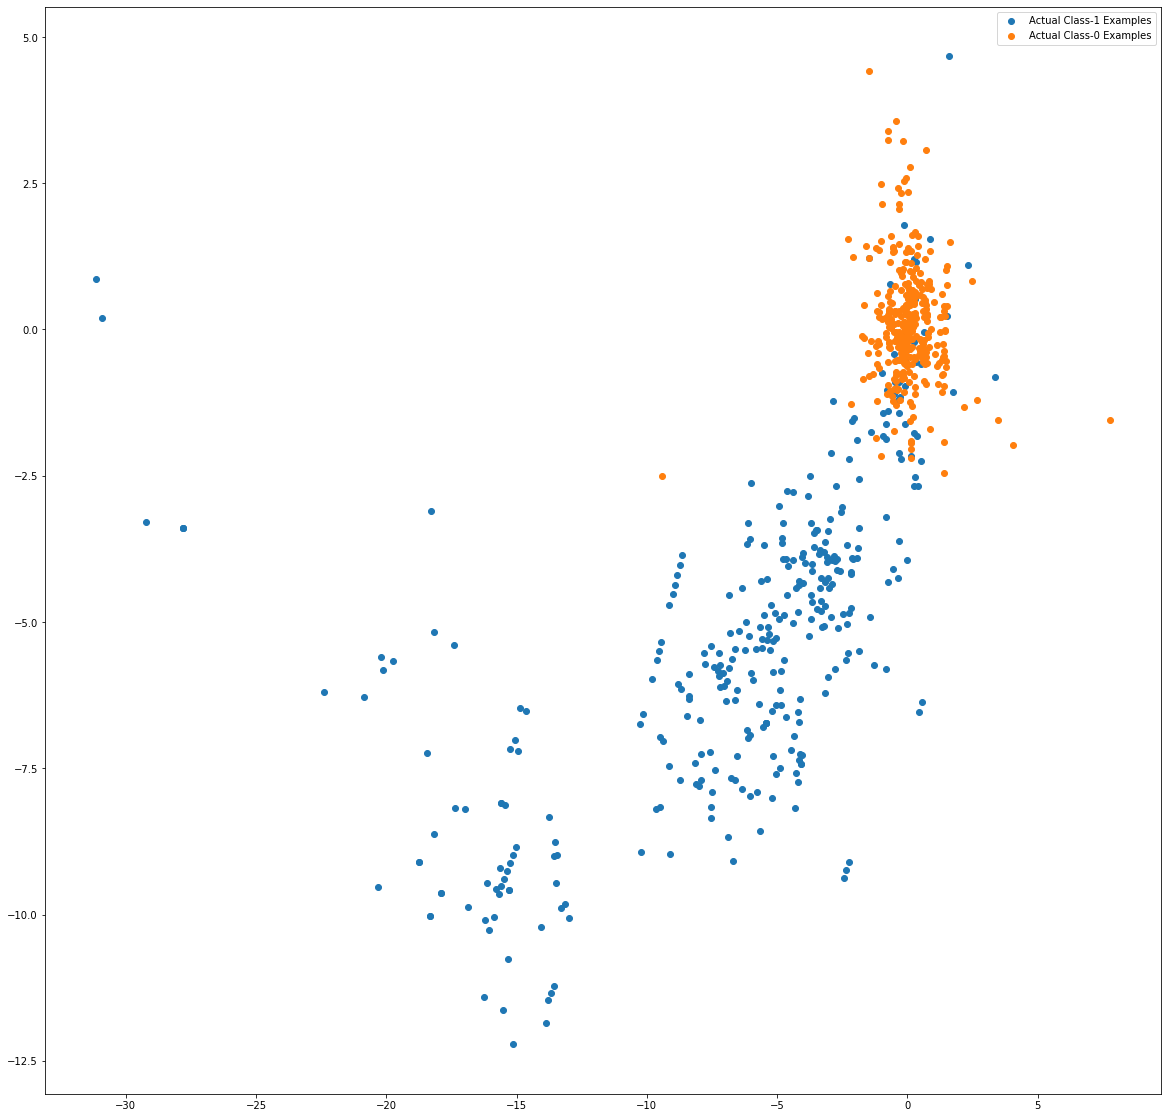

In [ ]:
#logistic regression does not have the feature_importance and you canfind by Coefficient Magnitude/Hypothesis Testing and Regularization etc..
# Since we got the best_model as XGBoost we can find using the below
best_model_xgb = metrics_df[metrics_df['Model'] == 'XGBoost']['Best_Model'].values[0]
var_imp = []
for i in best_model_xgb.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(best_model_xgb.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(best_model_xgb.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(best_model_xgb.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(best_model_xgb.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(best_model_xgb.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## RandomOverSampler

Random Oversampling (ROS) is a technique used to address class imbalance in a binary classification problem. It helps balance the class distribution by randomly duplicating instances from the minority class until the class distribution is approximately equal to that of the majority class. While ROS does increase the number of minority class samples and can improve the classifier's ability to learn from the minority class, it may not always be the best approach, and it has some potential drawbacks:

Overfitting: Random Oversampling can lead to overfitting. By duplicating instances from the minority class, you might risk making the model memorize the training data, which can result in poor generalization to unseen data.

Loss of Information: When you oversample, you may introduce duplicated information, leading to a loss of diversity in the data. This can affect the model's ability to capture the underlying patterns and may not always result in a better classifier.

Increased Training Time: With more instances in the dataset, the training time of your model may increase.

Data Leakage: If you use the same data for both training and testing, you might introduce data leakage, as the same instances may appear in both sets. Cross-validation is often used to mitigate this issue.

Impact on the Decision Boundary: Oversampling can influence the decision boundary of the classifier, potentially making it less conservative in classifying new data points.

Random Oversampling can be effective in certain situations, especially when you have a small dataset and cannot collect more samples of the minority class. However, it's essential to be aware of the potential drawbacks and to experiment with other techniques like Synthetic Minority Over-sampling Technique (SMOTE) and Adaptive Synthetic Sampling (ADASYN) to see if they provide better results for your specific problem. The choice of the method should depend on the characteristics of your data and the performance of the resulting model.

In [ ]:
X_ro_resampled, y_ro_resampled = perform_resampling(X_train , y_train, method='random')

In [ ]:
y_ro_resampled.value_counts()

0    199020
1    199020
Name: Class, dtype: int64

In [ ]:
X_ro_resampled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.267697,0.404782,-0.037582,-0.495586,0.417461,-0.450219,0.677525,-0.079224,-0.119844,-0.170534,...,-0.052398,-0.305036,-0.796136,0.056456,-0.669016,-0.954144,0.386449,0.578464,0.267038,-0.619494
1,1.167168,-0.201782,-1.385696,0.868101,0.434724,-0.791180,0.737052,-0.437967,-0.246955,0.508288,...,-0.042231,0.398622,0.722406,-0.385755,-0.641055,0.951240,-0.898773,-0.195537,-0.166521,1.119765
2,-0.792373,-2.385479,-0.987745,0.403150,-1.478402,-0.554012,1.280349,-0.714879,-1.218243,0.119978,...,2.863557,0.486079,-1.922162,-1.734577,0.838645,-0.304635,1.660302,-0.783775,0.704921,2.265229
3,-0.538573,0.640442,-0.551757,-0.515036,1.826026,2.172282,0.039457,0.777160,-0.250948,0.158587,...,0.289018,-0.251382,-0.976642,0.224379,1.768707,-1.469473,0.177960,0.016490,0.784726,-0.870972
4,-0.596658,0.056559,0.052907,-1.351635,1.933233,2.527105,-0.156943,0.944995,0.474378,-0.229042,...,0.196280,0.245843,1.050549,-0.527474,1.382820,-0.198843,1.242931,0.173308,-0.093808,-0.870972


## Model Building - RandomOverSampler
- Build different models on the balanced dataset and see the result

In [ ]:
models = {
    'Random Forest-ROS': (RandomForestClassifier(), {
        'n_estimators': [10, 50],
        'max_depth': [ 10,20,30]
    }),
    'Logistic Regression-ROS': (LogisticRegression(solver='lbfgs', max_iter=1000), {
        'C': [0.1, 1]
    }),
    'XGBoost-ROS' : (XGBClassifier(max_depth=2, n_estimators=200),{
                'learning_rate': [0.2, 0.6],
                'subsample': [0.3, 0.6, 0.9]
    }),
    'DecisionTree-ROS' : (DecisionTreeClassifier(),{
                'max_depth': range(5, 15, 5),
                'min_samples_leaf': range(50, 150, 50),
                'min_samples_split': range(50, 150, 50),

    }),
    'KNN-ROS' : (KNeighborsClassifier(),{
        'n_neighbors': [3, 5, 7],  # You can adjust the number of neighbors to search
        'weights': ['uniform', 'distance'],
    }),
    'SVM-ROS' : (SVC(probability=True),{
        'C': [0.1],  # You can adjust the regularization parameter
        'kernel': ['linear'],  # You can adjust the kernel type
    }),
}

Processing for the Model : RandomForestClassifier() 
Splitting train and test for the Model : RandomForestClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : RandomForestClassifier()  with hyperparamer {'n_estimators': [10, 50], 'max_depth': [10, 20, 30]}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................max_depth=10, n_estimators=10; total time=   6.0s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.9s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.9s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.9s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.8s
[CV] END ......................max_depth=10, n_estimators=50; total time=  30.1s
[CV] END ......................max_depth=10, n_estimators=50; total time=  29.2s
[CV] END ......................max_depth=10, n_estimators=50; total time= 

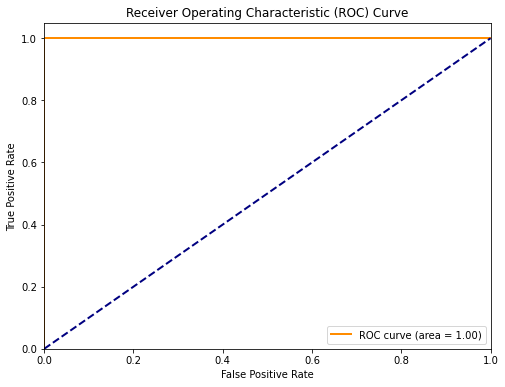

The CV results for the model RandomForestClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.843275,0.051803,0.057869,0.001511,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.999942,0.999907,0.999839,...,0.999921,4.521724e-05,6,0.999969,0.999962,0.999974,0.999967,0.999979,0.999970,0.000006
1,29.296203,0.334807,0.196464,0.002113,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.999986,0.999942,0.999958,...,0.999971,1.771945e-05,5,0.999976,0.999988,0.999984,0.999990,0.999988,0.999985,0.000005
2,6.473805,0.267242,0.060208,0.000936,20,10,"{'max_depth': 20, 'n_estimators': 10}",1.000000,1.000000,0.999965,...,0.999991,1.346438e-05,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,32.647258,0.821029,0.226234,0.007624,20,50,"{'max_depth': 20, 'n_estimators': 50}",1.000000,1.000000,1.000000,...,1.000000,0.000000e+00,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,6.734151,0.328246,0.061505,0.002227,30,10,"{'max_depth': 30, 'n_estimators': 10}",1.000000,0.999968,0.999983,...,0.999987,1.198074e-05,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,32.426976,0.653024,0.223419,0.007067,30,50,"{'max_depth': 30, 'n_estimators': 50}",1.000000,1.000000,1.000000,...,1.000000,4.965068e-17,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


The Metrics for the best score 1.0  and Best Estimator RandomForestClassifier(max_depth=20, n_estimators=50) 
Processing for the Model : LogisticRegression(max_iter=1000) 
Splitting train and test for the Model : LogisticRegression(max_iter=1000) 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : LogisticRegression(max_iter=1000)  with hyperparamer {'C': [0.1, 1]}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..............................................C=0.1; total time=   1.3s
[CV] END ..............................................C=0.1; total time=   1.2s
[CV] END ..............................................C=0.1; total time=   0.9s
[CV] END ..............................................C=0.1; total time=   1.1s
[CV] END ..............................................C=0.1; total time=   1.2s
[CV] END ................................................C=1; total time=   1.1s
[CV] END ...............................................

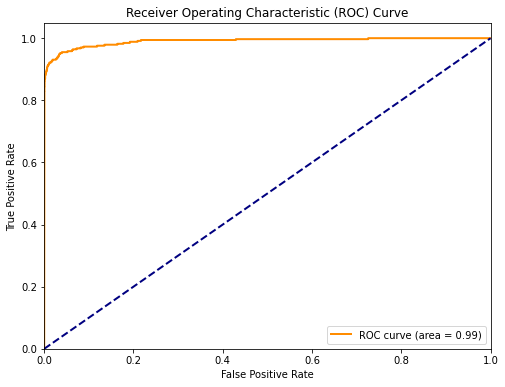

The CV results for the model LogisticRegression(max_iter=1000) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.128539,0.145291,0.021694,0.003500,0.1,{'C': 0.1},0.990757,0.990407,0.990295,0.990470,...,0.990411,0.000209,2,0.990341,0.990481,0.990482,0.990369,0.990486,0.990432,0.000063
1,1.072952,0.090950,0.024747,0.004142,1,{'C': 1},0.990772,0.990417,0.990314,0.990486,...,0.990427,0.000207,1,0.990360,0.990498,0.990500,0.990389,0.990505,0.990450,0.000063


The Metrics for the best score 0.990427342012158  and Best Estimator LogisticRegression(C=1, max_iter=1000) 
Processing for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Splitting train and test for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
       

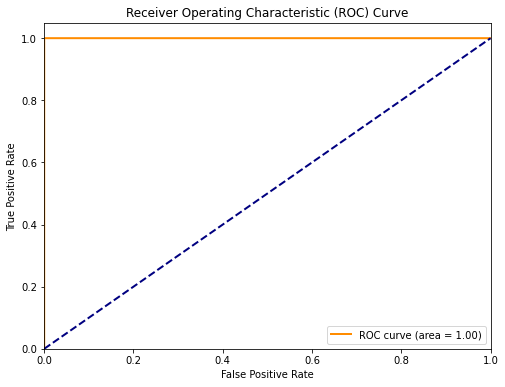

The CV results for the model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.548687,0.117865,0.042794,0.004647,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.999940,0.999862,0.999895,...,0.999912,0.000032,4,0.999939,0.999934,0.999935,0.999935,0.999916,0.999932,8.164001e-06
1,2.484010,0.045498,0.047104,0.004916,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.999937,0.999880,0.999868,...,0.999909,0.000032,5,0.999914,0.999941,0.999927,0.999923,0.999911,0.999923,1.072740e-05
2,2.315265,0.206972,0.044788,0.005086,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.999928,0.999854,0.999880,...,0.999906,0.000034,6,0.999912,0.999926,0.999929,0.999929,0.999913,0.999922,7.571305e-06
3,2.430349,0.095038,0.045104,0.006229,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.999962,0.999963,0.999931,...,0.999967,0.000022,3,0.999999,0.999999,1.000000,1.000000,1.000000,0.999999,5.735065e-07
4,2.575105,0.041760,0.054288,0.002524,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.999962,0.999984,0.999966,...,0.999980,0.000014,2,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,4.895409e-07
5,2.362583,0.065538,0.043018,0.007055,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.999973,0.999975,0.999970,...,0.999982,0.000011,1,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,5.666834e-07


The Metrics for the best score 0.9999817198238107  and Best Estimator XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Processing for the Model : DecisionTreeClassifier() 
Splitting train and test for the Model : DecisionTreeClassifier() 
Creating KFold object with 5 splits
Configuring hyper pa

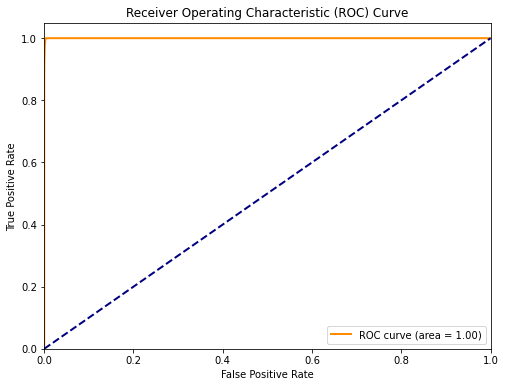

The CV results for the model DecisionTreeClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.599116,0.021435,0.020196,0.001081,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.995096,0.993753,...,0.994446,0.000461,5,0.994887,0.994033,0.994006,0.995005,0.994775,0.994541,0.000432
1,2.611543,0.018645,0.019810,0.000478,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.995096,0.993753,...,0.994446,0.000461,5,0.994887,0.994033,0.994006,0.995005,0.994775,0.994541,0.000432
2,2.621740,0.017949,0.019960,0.000389,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.994950,0.993593,...,0.994332,0.000484,7,0.994704,0.993867,0.993802,0.994891,0.994751,0.994403,0.000468
3,2.635007,0.022494,0.020252,0.001081,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.994950,0.993593,...,0.994332,0.000484,7,0.994704,0.993867,0.993802,0.994891,0.994751,0.994403,0.000468
4,3.350355,0.010028,0.022285,0.002769,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.999829,0.999681,...,0.999661,0.000098,1,0.999841,0.999841,0.999878,0.999842,0.999807,0.999842,0.000023
5,3.353566,0.029605,0.020068,0.000427,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.999830,0.999689,...,0.999618,0.000137,2,0.999841,0.999839,0.999878,0.999840,0.999807,0.999841,0.000023
6,3.348838,0.039203,0.020071,0.000311,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.999440,0.999594,...,0.999509,0.000053,3,0.999771,0.999742,0.999739,0.999819,0.999787,0.999771,0.000030
7,3.354196,0.018083,0.020415,0.000834,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.999410,0.999621,...,0.999486,0.000077,4,0.999771,0.999744,0.999739,0.999819,0.999787,0.999772,0.000030


The Metrics for the best score 0.9996605897508083  and Best Estimator DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50) 
Processing for the Model : KNeighborsClassifier() 
Splitting train and test for the Model : KNeighborsClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : KNeighborsClassifier()  with hyperparamer {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=  13.4s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  13.5s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  13.7s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  13.5s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  13.9s
[CV] END ....................n_neighbors=3, weights=distance; total time=  13.5s
[

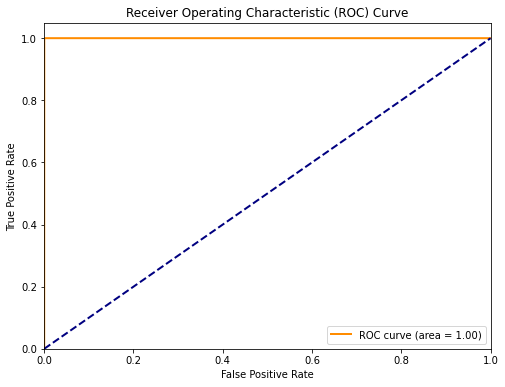

The CV results for the model KNeighborsClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.060377,0.016780,13.530292,0.172958,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.999858,0.999812,0.999764,...,0.999837,0.000044,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.050829,0.001166,13.609115,0.075737,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.999858,0.999812,0.999764,...,0.999837,0.000044,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.049347,0.001008,13.639894,0.097254,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.999858,0.999812,0.999764,...,0.999837,0.000044,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.053340,0.007150,13.507149,0.136084,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.999858,0.999812,0.999764,...,0.999837,0.000044,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.050358,0.001567,13.487335,0.116551,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.999858,0.999812,0.999764,...,0.999837,0.000044,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0.050220,0.001670,13.412877,0.128908,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.999858,0.999812,0.999764,...,0.999837,0.000044,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


The Metrics for the best score 0.9998366738395383  and Best Estimator KNeighborsClassifier(n_neighbors=3) 
Processing for the Model : SVC(probability=True) 
Splitting train and test for the Model : SVC(probability=True) 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : SVC(probability=True)  with hyperparamer {'C': [0.1], 'kernel': ['linear']}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
metrics_df = create_classification_report(models,metrics_df,X_ro_resampled, y_ro_resampled)

In [ ]:
metrics_df = create_model_threshold(models,metrics_df)

In [ ]:
display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))

## SMOTE

In [ ]:
X_train_smote, y_train_smote = perform_resampling(X_train, y_train, method='smote')

In [ ]:
y_train_smote.value_counts()

### Print the class distribution after applying SMOTE

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from imblearn import over_sampling

sm = over_sampling.SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:].to_numpy()

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()


## Model Building - SMOTE

In [ ]:
models = {
    'Random Forest-SMOTE': (RandomForestClassifier(), {
        'n_estimators': [10, 50],
        'max_depth': [ 10,20,30]
    }),
    'Logistic Regression-SMOTE': (LogisticRegression(solver='lbfgs', max_iter=1000), {
        'C': [0.1, 1]
    }),
    'XGBoost-SMOTE' : (XGBClassifier(max_depth=2, n_estimators=200),{
                'learning_rate': [0.2, 0.6],
                'subsample': [0.3, 0.6, 0.9]
    }),
    'DecisionTree-SMOTE' : (DecisionTreeClassifier(),{
                'max_depth': range(5, 15, 5),
                'min_samples_leaf': range(50, 150, 50),
                'min_samples_split': range(50, 150, 50),

    }),
    'KNN-SMOTE' : (KNeighborsClassifier(),{
        'n_neighbors': [3, 5, 7],  # You can adjust the number of neighbors to search
        'weights': ['uniform', 'distance'],
    }),
    'SVM-SMOTE' : (SVC(probability=True),{
        'C': [0.1],  # You can adjust the regularization parameter
        'kernel': ['linear'],  # You can adjust the kernel type
    }),


In [ ]:
metrics_df = create_classification_report(models,metrics_df,X_train_smote, y_train_smote)

In [ ]:
metrics_df = create_model_threshold(models,metrics_df)

In [ ]:
display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))

##### Build models on other algorithms to see the better performing on SMOTE

### Print the class distribution after applying ADASYN

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:].to_numpy()

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()
plt.show()

##### Build models on other algorithms to see the better performing on ADASYN

In [ ]:
models = {
    'Random Forest-ADASYN': (RandomForestClassifier(), {
        'n_estimators': [10, 50],
        'max_depth': [ 10,20,30]
    }),
    'Logistic Regression-ADASYN': (LogisticRegression(solver='lbfgs', max_iter=1000), {
        'C': [0.1, 1]
    }),
    'XGBoost-ADASYN' : (XGBClassifier(max_depth=2, n_estimators=200),{
                'learning_rate': [0.2, 0.6],
                'subsample': [0.3, 0.6, 0.9]
    }),
    'DecisionTree-ADASYN' : (DecisionTreeClassifier(),{
                'max_depth': range(5, 15, 5),
                'min_samples_leaf': range(50, 150, 50),
                'min_samples_split': range(50, 150, 50),

    }),
    'KNN-ADASYN' : (KNeighborsClassifier(),{
        'n_neighbors': [3, 5, 7],  # You can adjust the number of neighbors to search
        'weights': ['uniform', 'distance'],
    }),
    'SVM-ADASYN' : (SVC(probability=True),{
        'C': [0.1],  # You can adjust the regularization parameter
        'kernel': ['linear'],  # You can adjust the kernel type
    }),
}


In [ ]:
metrics_df = create_classification_report(models,metrics_df,X_train_adasyn, y_train_adasyn)

In [ ]:
metrics_df = create_model_threshold(models,metrics_df)

In [ ]:
display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))

### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [ ]:
asasssad

In [ ]:
display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))

In [ ]:
# perform the best oversampling method on X_train & y_train

clf = metrics_df[metrics_df['Model'] == 'Random Forest-ROS']['Best_Model'].values[0]  #initialise the model with optimum hyperparameters
clf.fit(X_ro_resampled, y_ro_resampled) # fit on the balanced dataset
#print() --> #print the evaluation score on the X_test by choosing the best evaluation metric

In [ ]:
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve

best_model_score = clf.score(X_test, y_test)
print('Model Accuracy: {0}'.format(best_model_score))

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
sensitivity = TP / float(TP+FN)
specificity = TN / float(TN+FP)

# Calculate ROC curve and ROC AUC score
y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
threshold = thresholds[np.argmax(tpr-fpr)]

metrics_info = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': confusion,
        'ROC AUC': roc_auc,
        'sensitivity':sensitivity,
        'specificity' : specificity,
        'Best_Model' : clf,
        'threshold'  : threshold
     }

In [ ]:
metrics_info

### Print the important features of the best model to understand the dataset

In [ ]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#### Print the FPR,TPR & select the best threshold from the roc curve

In [ ]:
print('Train auc =', metrics.roc_auc_score(y_test, y_prob))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
threshold = thresholds[np.argmax(tpr-fpr)]
print('Threshold fromthe roc curve =' ,threshold)